In [2]:
import openslide
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cancer_img_dir = os.getcwd() + "/Projects/LUAD-WSI/data/cancer_img/"
cancer_ori_img_dir = os.getcwd() + "/Projects/LUAD-WSI/data/cancer_img_ori/"
control_img_dir = os.getcwd() + "/Projects/LUAD-WSI/data/control_img/"

cancer_files = os.listdir(cancer_img_dir)
cancer_ori_files = os.listdir(cancer_ori_img_dir)
control_files = os.listdir(control_img_dir)

# print "cancer original imgs"
# for i in range(len(cancer_ori_files)):
#     wsi = openslide.OpenSlide(filename=cancer_ori_img_dir + cancer_ori_files[i])
#     print "wsi.level_count", wsi.level_count
#     print "wsi.dimensions", wsi.dimensions
#     print "wsi.level_dimensions", wsi.level_dimensions
#     print "wsi.level_downsamples", wsi.level_downsamples
#     print "wsi.properties", wsi.properties
#     print "wsi.associated_images", wsi.associated_images
#     print cancer_ori_files[i], wsi.dimensions
#     region_image = wsi.read_region(location=(0, 0), level=0, size=wsi.dimensions)
#     plt.imshow(region_image)
#     plt.show()

# print "cancer imgs"
# for i in range(len(cancer_files)):
#     wsi = openslide.OpenSlide(filename=cancer_img_dir + cancer_files[i])
#     print cancer_files[i], wsi.dimensions
#     region_image = wsi.read_region(location=(0, 0), level=0, size=wsi.dimensions)
#     plt.imshow(region_image)
#     plt.show()
#     
# print "control imgs"
# for i in range(len(control_files)):
#     wsi = openslide.OpenSlide(filename=control_img_dir + control_files[i])
#     # print "wsi.level_count", wsi.level_count
#     # print "wsi.dimensions", wsi.dimensions
#     # print "wsi.level_dimensions", wsi.level_dimensions
#     # print "wsi.level_downsamples", wsi.level_downsamples
#     # print "wsi.properties", wsi.properties
#     # print "wsi.associated_images", wsi.associated_images
#     print control_files[i], wsi.dimensions
#     region_image = wsi.read_region(location=(0, 0), level=0, size=wsi.dimensions)
#     plt.imshow(region_image)
#     plt.show()

(943, 800)


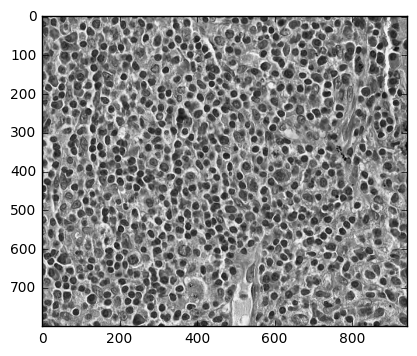

In [5]:
wsi = openslide.OpenSlide(filename=cancer_img_dir + cancer_files[3])
print wsi.dimensions
region_image = wsi.read_region(location=(0, 0), level=0, size=wsi.dimensions).convert("L")
plt.imshow(region_image, cmap="gray")
region_image
plt.show()

(2000, 256)
10.9320622797


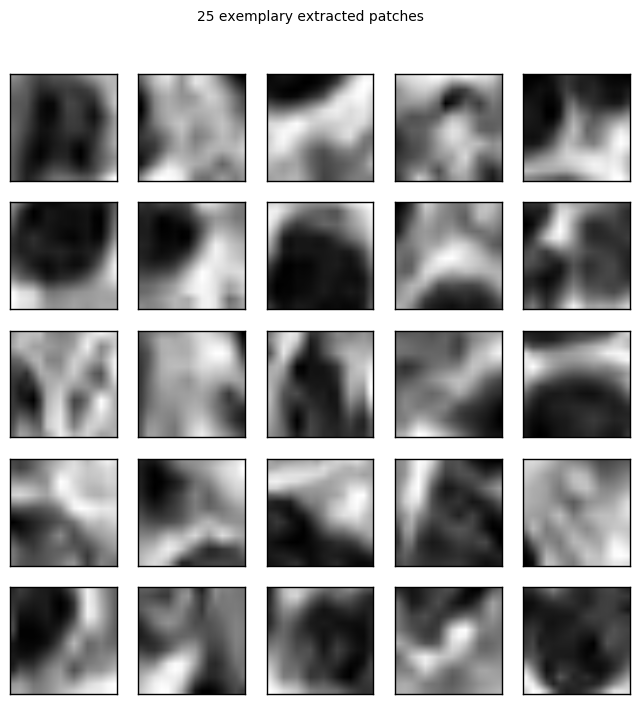

In [7]:
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn import preprocessing

patch_width = 16
n_patches = 2000
n_channels = 1

img_data = np.asarray(region_image)
# img_data = img_data[:,:,:3] # remove alpha channel

patches = extract_patches_2d(img_data, (patch_width, patch_width), max_patches=n_patches, random_state=2)

patches = patches.reshape((n_patches, -1))
print patches.shape
patches = preprocessing.scale(patches, axis=0, copy=False)
print np.linalg.norm(patches[0])

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(patches[i].reshape((patch_width, patch_width), order="C"), cmap="gray")
    plt.xticks([])
    plt.yticks([])
_ = plt.suptitle("25 exemplary extracted patches")
plt.show()

Run sparse coding on extracted patches to find tumor-specific features

In [8]:
from sklearn.decomposition import sparse_encode, MiniBatchDictionaryLearning

n_components = 500

dl = MiniBatchDictionaryLearning(n_components, batch_size=200, n_jobs=4, transform_algorithm='omp', verbose=0)
dl.fit(patches)

components = dl.components_
print components.shape

(500, 256)


components.shape (500, 256)


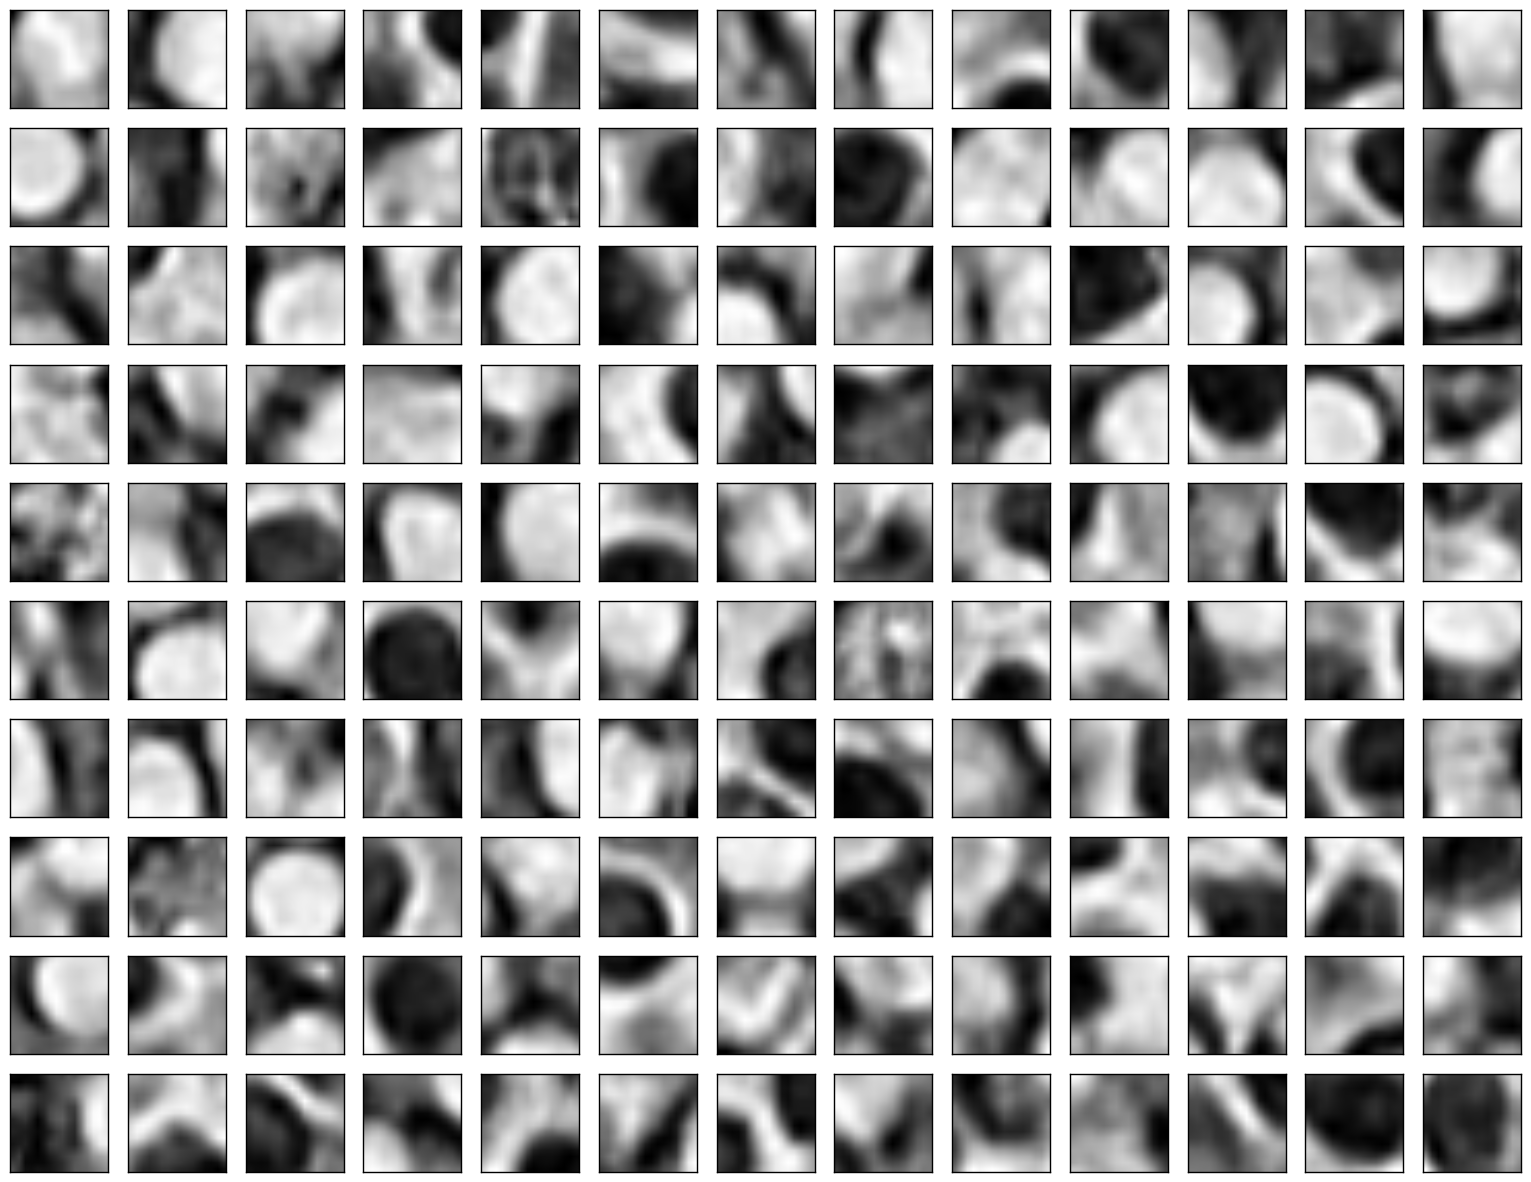

In [9]:
def plot_gallery(title, images, w, h, n_row=10, n_col=10, titles=None):
    plt.figure(figsize=(1.5 * n_col, 1.5 * n_row))
    plt.title(title)
    # plt.subplots_adjust(bottom=0.1, left=.01, right=.99, top=.90, hspace=.1)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((w, h), order='C'), origin='upper', cmap="gray")
        if (titles!=None): plt.title(titles[i], size=8) 
        plt.xticks(())
        plt.yticks(())

print "components.shape", components.shape
plot_gallery("Visualizing top components", components, patch_width, patch_width, n_row=10, n_col=13)
plt.show()

TCGA-44-6147-01B-05-BS5 (2).svs (1676, 924)


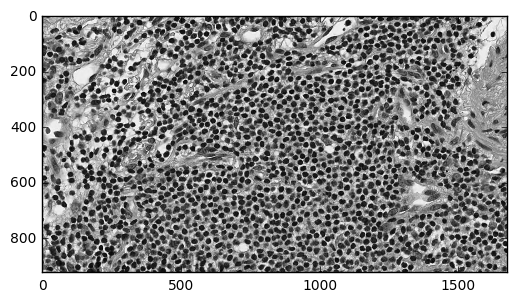

In [10]:
wsi = openslide.OpenSlide(filename=control_img_dir+ control_files[3])
print control_files[3], wsi.dimensions
region_image = wsi.read_region(location=(0, 0), level=0, size=wsi.dimensions).convert("L")
img_data = np.asarray(region_image)
plt.imshow(region_image, cmap="gray")
region_image
plt.show()

In [11]:
n_test_patches = 10
testing_patches = extract_patches_2d(img_data, (patch_width, patch_width), max_patches=n_test_patches, random_state=2)

testing_patches = testing_patches.reshape(-1, patch_width*patch_width*n_channels)
testing_patches = preprocessing.scale(testing_patches, axis=0, copy=False)

plot_gallery("Test patches", testing_patches, patch_width, patch_width, n_row=1, n_col=10)

In [12]:
test_patches_code = sparse_encode(testing_patches, components, algorithm="lars", verbose=0)

In [13]:
print test_patches_code.shape
# plt.hist(test_patches_code.reshape(-1), bins=50)
# plt.xlabel("Activation")
# plt.ylabel("Count")
# _ = plt.title("Feature activation histogram")
# plt.show()

(10, 500)


(10,)


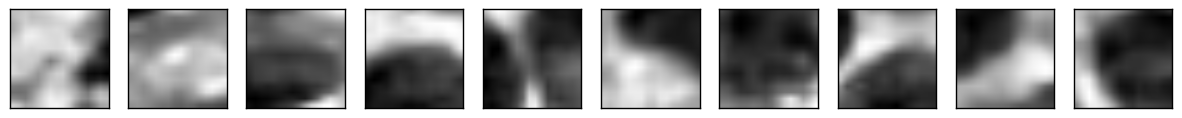

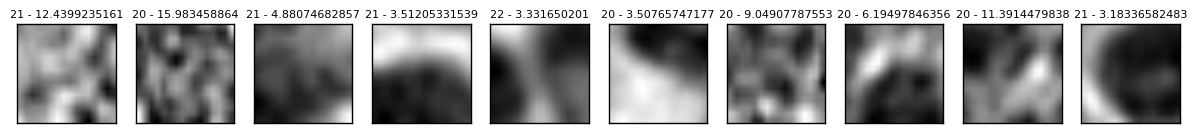

In [14]:
reconstructed_test_patches = np.dot(test_patches_code, components)
error = reconstructed_test_patches - testing_patches
error = np.linalg.norm(error, axis=1)
print error.shape
n_nonzero_code = ['{1} - {0}'.format(error[i], np.count_nonzero(test_patches_code[i])) for i in range(len(test_patches_code))]

plot_gallery("Test reconstructed_test_patches", reconstructed_test_patches, patch_width, patch_width, n_row=1, n_col=10, titles=n_nonzero_code)
plt.show()

01.TCGA-44-6146-01B-03-TS3-original.svs (45006, 33302)


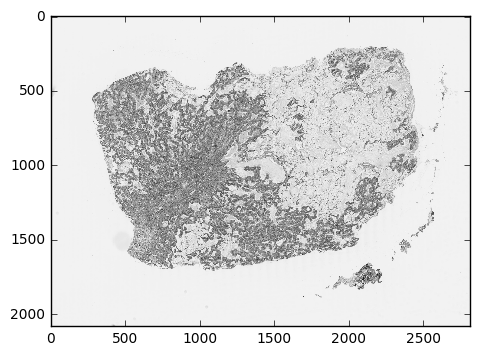

In [15]:
wsi = openslide.OpenSlide(filename=cancer_ori_img_dir + cancer_ori_files[0])
print cancer_ori_files[0], wsi.dimensions
region_image = wsi.read_region(location=(0, 0), level=2, size=wsi.level_dimensions[2]).convert("L")
img_data = np.asarray(region_image)
plt.imshow(region_image, cmap="gray")
region_image
plt.show()